In [1]:
from circuit_knitting.cutting import partition_problem
from qiskit.circuit import QuantumCircuit, ParameterVector
# from quantum_image_processing.neural_networks import QCNN
# from quantum_image_processing.neural_networks.layers import QuantumConvolutionalLayer, QuantumPoolingLayer2, FullyConnectedLayer
from qiskit.quantum_info import SparsePauliOp, PauliList
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from qiskit.visualization import circuit_drawer
from qiskit_machine_learning.neural_networks.estimator_qnn import EstimatorQNN
from qiskit_machine_learning.neural_networks.sampler_qnn import SamplerQNN
# from quantum_image_processing.data_loader.mnist_data_loader import load_mnist_data
# from quantum_image_processing.data_encoder.angle_encoder import angle_encoding
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_algorithms.optimizers.cobyla import COBYLA
from qiskit.algorithms.optimizers import ADAM, SPSA
from qiskit_algorithms.utils import algorithm_globals
from IPython.display import clear_output

/var/folders/3j/3p_dzlvs1nsdfryf9hm7gjnr0000gn/T/ipykernel_45022/4111609774.py:17: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed in Qiskit 1.0. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import ADAM, SPSA


In [2]:
seed = 100

## Data Loading

In [3]:
# Load data
data = pd.read_csv("diabetes_normalized.csv")
data = data.drop(["Unnamed: 0"], axis=1)
# data = data.drop(["BMI", "SkinThickness", "Pregnancies"], axis=1)
data.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-0.923998,1.531329,0.566517,-0.920265,-3.141593,0.004682,-1.66872,-0.104720,1
1,-2.771994,-0.457820,0.257508,-1.301064,-3.141593,-0.650792,-2.40918,-2.094395,0


In [4]:
y = data["Outcome"]
x = data.drop(["Outcome"], axis=1)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(537, 8) (537,) (231, 8) (231,)


In [6]:
x_train_A = x_train.iloc[:, :4]
x_train_B = x_train.iloc[:, 4:]
# x_train.iloc[:, 4:]

In [7]:
x_test_A = x_test.iloc[:, :4]
x_test_B = x_test.iloc[:, 4:]

In [8]:
# y_train

## Data Embedding

In [9]:
# Data Embedding - Angle Encoding
def angle_encoding(feature_dims: int):
    embedding = QuantumCircuit(feature_dims)
    feature_param = ParameterVector("Theta", feature_dims)
    for qubit in range(feature_dims):
        embedding.ry(feature_param[qubit], qubit)
    return embedding, feature_param

In [10]:
embedding, feature_params = angle_encoding(4)

## Tensor Network

In [11]:
from quantum_image_processing.tensor_network_circuits import TTN

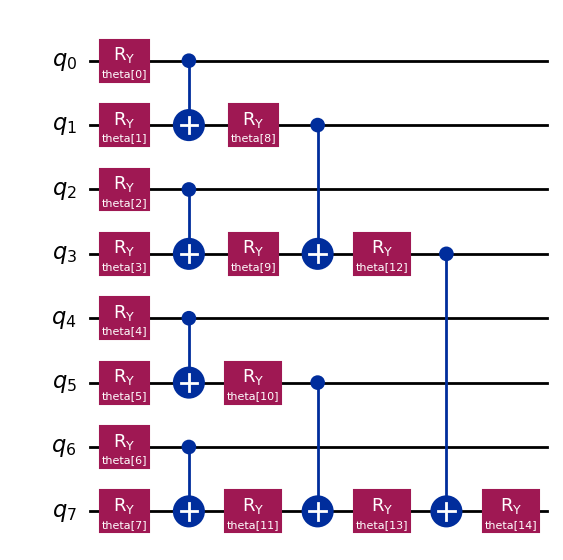

In [12]:
ttn = TTN(num_qubits=8).ttn_simple(complex_structure=False)
ttn.draw("mpl", style="iqp")

In [13]:
ttn.parameters

ParameterView([ParameterVectorElement(theta[0]), ParameterVectorElement(theta[1]), ParameterVectorElement(theta[2]), ParameterVectorElement(theta[3]), ParameterVectorElement(theta[4]), ParameterVectorElement(theta[5]), ParameterVectorElement(theta[6]), ParameterVectorElement(theta[7]), ParameterVectorElement(theta[8]), ParameterVectorElement(theta[9]), ParameterVectorElement(theta[10]), ParameterVectorElement(theta[11]), ParameterVectorElement(theta[12]), ParameterVectorElement(theta[13]), ParameterVectorElement(theta[14])])

## Circuit Cutting

In [14]:
observables = PauliList(["ZIIIIIII"])
partitioned_problem = partition_problem(circuit=ttn, partition_labels="AAAABBBB", observables=observables)
sub_circuits = partitioned_problem.subcircuits
sub_observables = partitioned_problem.subobservables
bases = partitioned_problem.bases

In [15]:
sub_observables

{'A': PauliList(['IIII']), 'B': PauliList(['ZIII'])}

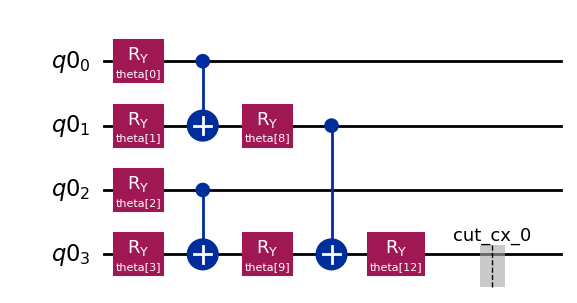

In [16]:
sub_circuits["A"].draw("mpl", style="iqp")

In [17]:
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

Sampling overhead: 9.0


### Sub Experiments

In [18]:
from circuit_knitting.cutting import generate_cutting_experiments

subexperiments, coefficients = generate_cutting_experiments(
    circuits=sub_circuits, observables=sub_observables, num_samples=np.inf
)

In [19]:
# subexperiments
len(subexperiments["A"])

6

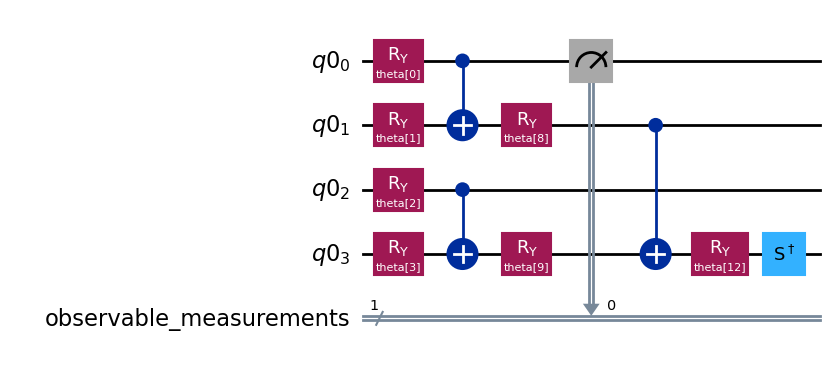

In [20]:
subexperiments["A"][0].draw("mpl", style="iqp")

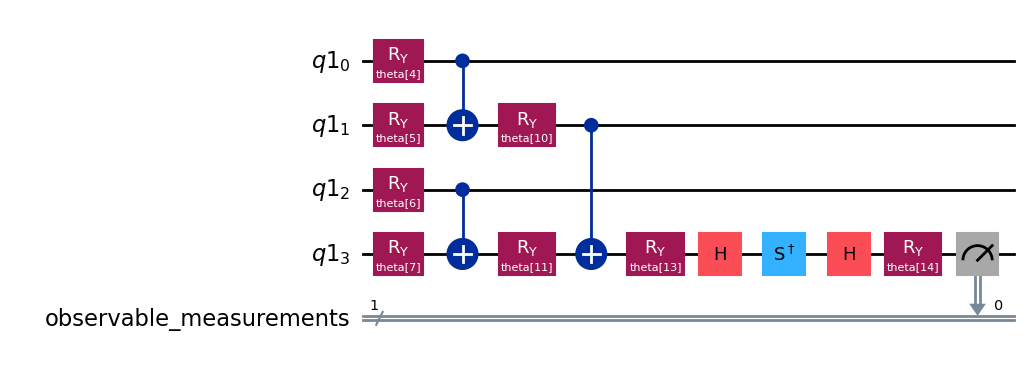

In [21]:
subexperiments["B"][0].draw("mpl", style="iqp")

## Neural Network Training

In [22]:
from qiskit_machine_learning.algorithms import BinaryObjectiveFunction
from qiskit_machine_learning.neural_networks import SamplerQNN, NeuralNetwork
from qiskit_machine_learning.utils.loss_functions import L2Loss
from qiskit_algorithms.optimizers import COBYLA
from qiskit_aer.primitives import Sampler
from typing import Callable

### Sampler

In [23]:
from custom_sampler_qnn import CustomSampler

#### For subexperiments["A"]

In [24]:
final_circuits = [embedding.compose(subex_circuit, inplace=False) for subex_circuit in subexperiments["A"]]
# final_circuits[0].draw("mpl")

In [25]:
sampler_qcnn = CustomSampler(
    circuits=final_circuits, 
    input_params=feature_params.params,
    weight_params=sub_circuits["A"].parameters,
)

In [26]:
weights_A = algorithm_globals.random.random(7)
forward_output, forward_sampler_result = sampler_qcnn._forward(
    input_data=x_train_A,
    weights=weights_A,
)

In [27]:
print(f"Output shape for {len(x_train_A)} samples: {forward_output[0].shape}")
print(f"Output of the forward pass for first sample: {forward_output[0]}")

Output shape for 537 samples: (6, 16)
Output of the forward pass for first sample: [[0.04278804 0.95721196 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.04278804 0.95721196 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.02349678 0.53086836 0.01929125 0.42634361 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.02349678 0.53086836 0.01929125 0.42634361 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.04278804 0.95721196 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.04278804 0.95721196 0.         0.         0.         0.
  0.         0.       

In [28]:
# OLD
# forward_output_quasi_dists = {
#     index: result.quasi_dists 
#     for index, result in forward_output.items()
# }

# print("Forward output", forward_output)
# print(forward_output_quasi_dists[0][0])
# print(f"Total results for per sample: {len(forward_output_quasi_dists)}")
# print(f"Total samples: {len(forward_output_quasi_dists[0])}")

In [ ]:
input_grad, weights_grad, backward_sampler_result = sampler_qcnn._backward(
    input_data=x_train_A,
    weights=weights_A
)

In [ ]:
print(f"Output shape for {len(x_train_A)} samples: {weights_grad.shape}")
print(f"Output of the backward pass for first sample for first subexperiment circuit: {weights_grad[536][5]}")

In [ ]:
# OLD
# backward_output_gradients = {
#     index: result.gradients 
#     for index, result in backward_output.items()
# }
# backward_output_gradients

# Gradients per parameter value
# print(f"Gradients of {len(backward_output_gradients[0][0])} parameters are: {backward_output_gradients[0][0]}")
# print(f"Total results for per sample: {len(backward_output_gradients)}")
# print(f"Total samples: {len(backward_output_gradients[0])}")

#### For subexperiments["B"]

In [ ]:
final_circuits2 = [embedding.compose(subex_circuit, inplace=False) for subex_circuit in subexperiments["B"]]

In [ ]:
sampler_qcnn2 = CustomSampler(
    circuits=final_circuits, 
    input_params=feature_params.params,
    weight_params=sub_circuits["B"].parameters,
)

In [ ]:
weights_B = algorithm_globals.random.random(8)
forward_output2 = sampler_qcnn._forward(
    input_data=x_train_B,
    weights=weights_B,
)

In [ ]:
print(f"Output shape for {len(x_train_B)} samples: {forward_output2[0].shape}")
print(f"Output of the forward pass for first sample: {forward_output2[0]}")

In [ ]:
input_grad2, weights_grad2 = sampler_qcnn._backward(
    input_data=x_train_B,
    weights=weights_B
)

In [ ]:
print(f"Output shape for {len(x_train_B)} samples: {weights_grad2.shape}")
print(f"Output of the backward pass for first sample for first subexperiment circuit: {weights_grad2[536][6]}")

## Reconstruct Expectation Values

In [ ]:
forward_sampler_result

In [ ]:
backward_sampler_result

In [ ]:
from circuit_knitting.cutting import reconstruct_expectation_values

In [ ]:
# results here need to be sampler results.
combined_results = {
    
}

In [ ]:
reconstructed_expvals = reconstruct_expectation_values(
    results,
    coefficients,
    subobservables,
)

#### Loss and Optimization

In [ ]:
# neural_network needs to be of the type NeuralNetwork (For example, SamplerQNN or EstimatorQNN)
# samplers = 
# neural_network = 
loss = L2Loss()
optimizer = COBYLA(maxiter=10)

In [ ]:
def create_objective(X: np.ndarray, y: np.ndarray, neural_network, loss):
    return BinaryObjectiveFunction(X, y, neural_network, loss)

In [ ]:
def fit(X: np.ndarray, y: np.ndarray):
    function = create_objective(X, y)
    return minimize(function)

In [ ]:
def minimize(function, initial_point, optimizer: Callable):
    if callable(optimizer):
        optimizer_result = optimizer(
            fun=objective, x0=initial_point, jac=function.gradient
        )
    else:
        optimizer_result = optimizer.minimize(
            fun=objective,
            x0=initial_point,
            jac=function.gradient,
        )
    return optimizer_result

In [ ]:
# Do we need postprocessing?
# Postprocessing method gives probabilities but we need
# expectation values so that we can reconstruct the og_circuit exp_vals


In [ ]:
# def preprocess_forward(input_data, weights, num_subexperiments):
#     if input_data is not None:
#         num_samples = input_data.shape[0]
#         if weights is not None:
#             weights = np.broadcast_to(weights, (num_samples, len(weights)))
#             parameters = np.concatenate((input_data, weights), axis=1)
#         else:
#             parameters = input_data
#     else:
#         if weights is not None:
#             num_samples = 1
#             parameters = np.broadcast_to(weights, (num_samples, len(weights)))
#         else:
#             # no input, no weights, just execute circuit once
#             num_samples = 1
#             parameters = np.asarray([])

#     # Increase num_params to include subexperiments
#     parameters = [[params] * num_subexperiments for params in parameters]
    
#     # print("params", len(parameters), len(parameters[0]), len(parameters[0][0]))
#     return parameters, num_samples

In [ ]:
num_subexperiments = 6
weights = algorithm_globals.random.random(7)
parameters, num_samples = preprocess_forward(x_train_A, weights, num_subexperiments)
# parameters combines input_data and weights
print("Results", parameters[0], len(parameters[0]), len(parameters[0][0]), num_samples)

In [ ]:
# Create objective function
objective = create_objective(x_train, y_train, neural_network, loss)
objective

In [ ]:
initial_point = algorithm_globals.random.random(neural_network.num_weights)
initial_point

In [ ]:
# Call fit
optimizer_result = minimize(objective, )

#### NeuralNetworkClassifier

In [ ]:
def callback_graph(weights, obj_func_eval):
    # clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    print(f"COBYLA Epoch {len(objective_func_vals)}: {obj_func_eval:.5f}")

## Reconstruct Expectation value

In [ ]:
from circuit_knitting.cutting import reconstruct_expectation_values

reconstructed_expvals = reconstruct_expectation_values(
    results,
    coefficients,
    sub_observables,
)

In [ ]:
reconstructed_expvals